In [ ]:
# default_exp experiments.utils

In [ ]:
#export
ENV_VARS = dict(OMP_NUM_THREADS='2',
                OPENBLAS_NUM_THREADS='2',
                MKL_NUM_THREADS='3',
                VECLIB_MAXIMUM_THREADS='2',
                NUMEXPR_NUM_THREADS='3')

In [ ]:
# export
import os
# Limit number of threads in numpy and others to avoid throttling
os.environ.update(ENV_VARS)
import random
import time
from functools import partial

import numpy as np
import pandas as pd
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

from nixtla.data.scalers import Scaler
from nixtla.data.tsdataset import TimeSeriesDataset
from nixtla.data.tsloader_general import TimeSeriesLoader
from nixtla.models.esrnn.esrnn import ESRNN
from nixtla.models.esrnn.mqesrnn import MQESRNN
from nixtla.models.esrnn.rnn import RNN
from nixtla.models.nbeats.nbeats import Nbeats
from nixtla.models.tcn.tcn import TCN

In [ ]:
# export
def get_default_mask_df(Y_df, ds_in_test, is_test):
    # Creates outsample_mask
    # train 1 validation 0
    last_df = Y_df.copy()[['unique_id', 'ds']]
    last_df.sort_values(by=['unique_id', 'ds'], inplace=True, ascending=False)
    last_df.reset_index(drop=True, inplace=True)

    last_df = last_df.groupby('unique_id').head(ds_in_test)
    last_df['sample_mask'] = 0

    last_df = last_df[['unique_id', 'ds', 'sample_mask']]

    mask_df = Y_df.merge(last_df, on=['unique_id', 'ds'], how='left')
    mask_df['sample_mask'] = mask_df['sample_mask'].fillna(1)

    mask_df = mask_df[['unique_id', 'ds', 'sample_mask']]
    mask_df.sort_values(by=['unique_id', 'ds'], inplace=True)
    mask_df['available_mask'] = 1

    assert len(mask_df)==len(Y_df), \
        f'The mask_df length {len(mask_df)} is not equal to Y_df length {len(Y_df)}'

    if is_test:
        mask_df['sample_mask'] = 1 - mask_df['sample_mask']

    return mask_df

In [ ]:
#export
def scale_data(Y_df, X_df, mask_df, normalizer_y, normalizer_x):
    y_shift = None
    y_scale = None

    # mask = mask.astype(int)
    mask = mask_df['available_mask'].values * mask_df['sample_mask'].values
    
    if normalizer_y is not None:
        scaler_y = Scaler(normalizer=normalizer_y)
        Y_df['y'] = scaler_y.scale(x=Y_df['y'].values, mask=mask)
    else:
        scaler_y = None

    if normalizer_x is not None:
        X_cols = [col for col in X_df.columns if col not in ['unique_id','ds']]
        for col in X_cols:
            scaler_x = Scaler(normalizer=normalizer_x)
            X_df[col] = scaler_x.scale(x=X_df[col].values, mask=mask)

    return Y_df, X_df, scaler_y

In [ ]:
# export
def train_val_split(len_series, offset, window_sampling_limit, n_val_weeks, ds_per_day):
    last_ds = len_series - offset
    first_ds = max(last_ds - window_sampling_limit, 0)

    last_day = int(last_ds/ds_per_day)
    first_day = int(first_ds/ds_per_day)

    days = set(range(first_day, last_day)) # All days, to later get train days
    # Sample weeks from here, -7 to avoid sampling from last week
    # To not sample first week and have inputs
    sampling_days = set(range(first_day + 7, last_day - 7))
    validation_days = set({}) # Val days set
    
    # For loop for n of weeks in validation
    for i in range(n_val_weeks):
        # Sample random day, init of week
        init_day = random.sample(sampling_days, 1)[0]
        # Select days of sampled init of week
        sampled_days = list(range(init_day, min(init_day+7, last_day)))
        # Add days to validation days
        validation_days.update(sampled_days)
        # Remove days from sampling_days, including overlapping resulting previous week
        days_to_remove = set(range(init_day-6, min(init_day+7, last_day)))
        sampling_days = sampling_days.difference(days_to_remove)

    train_days = days.difference(validation_days)

    train_days = sorted(list(train_days))
    validation_days = sorted(list(validation_days))

    train_idx = []
    for day in train_days:
        hours_idx = range(day*ds_per_day,(day+1)*ds_per_day)
        train_idx += hours_idx

    val_idx = []
    for day in validation_days:
        hours_idx = range(day*ds_per_day,(day+1)*ds_per_day)
        val_idx += hours_idx

    assert all([idx < last_ds for idx in val_idx]), 'Leakage!!!!'
    
    return train_idx, val_idx

In [ ]:
# export
def create_datasets(mc, Y_df, X_df, S_df, ds_in_test, shuffle_outsample):
    #TODO: shuffle_outsample

    # n_timestamps_pred defines number of hours ahead to predict
    
    #------------------------------------- Available and Validation Mask ------------------------------------#
    # mask: 1 last_n_timestamps, 0 timestamps until last_n_timestamps
    train_mask_df = get_default_mask_df(Y_df=Y_df, ds_in_test=ds_in_test, is_test=False)
    outsample_mask_df = get_default_mask_df(Y_df=Y_df, ds_in_test=ds_in_test, is_test=True)

    #---------------------------------------------- Scale Data ----------------------------------------------#
    # Scale data # TODO: write sample_mask conditional/groupby(['unique_id]) scaling
    Y_df, X_df, scaler_y = scale_data(Y_df=Y_df, X_df=X_df, mask_df=train_mask_df,
                                      normalizer_y=mc['normalizer_y'], normalizer_x=mc['normalizer_x'])

    #----------------------------------------- Declare Dataset and Loaders ----------------------------------#
    train_ts_dataset = TimeSeriesDataset(Y_df=Y_df, X_df=X_df, S_df=S_df, mask_df=train_mask_df, verbose=True)
    if ds_in_test == 0:
        outsample_ts_dataset = None
    else:
        outsample_ts_dataset = TimeSeriesDataset(Y_df=Y_df, X_df=X_df, S_df=S_df, 
                                                 mask_df=outsample_mask_df, verbose=True)

#     train_ts_dataset = TimeSeriesDataset(Y_df=Y_df, S_df=None, X_df=X_df,
#                                      ds_in_test=728*24, verbose=True)

#     outsample_ts_dataset = TimeSeriesDataset(Y_df=Y_df, S_df=None, X_df=X_df,
#                                             ds_in_test=728*24, is_test=True, verbose=True)

#     scaler_y = None

    return train_ts_dataset, outsample_ts_dataset, scaler_y

In [ ]:
# export
def instantiate_loaders(mc, train_ts_dataset, outsample_ts_dataset):
    train_ts_loader = TimeSeriesLoader(ts_dataset=train_ts_dataset,
                                       model=mc['model'],
                                       window_sampling_limit=int(mc['window_sampling_limit']),
                                       input_size=int(mc['input_size_multiplier']*mc['output_size']),
                                       output_size=int(mc['output_size']),
                                       idx_to_sample_freq=int(mc['idx_to_sample_freq']),
                                       len_sample_chunks=mc['len_sample_chunks'],
                                       batch_size=int(mc['batch_size']),
                                       n_series_per_batch=mc['n_series_per_batch'],
                                       complete_inputs=mc['complete_inputs'],
                                       complete_sample=mc['complete_sample'],
                                       shuffle=True)

    if outsample_ts_dataset is not None:
        val_ts_loader = TimeSeriesLoader(ts_dataset=outsample_ts_dataset,
                                        model=mc['model'],
                                        window_sampling_limit=int(mc['window_sampling_limit']),
                                        input_size=int(mc['input_size_multiplier']*mc['output_size']),
                                        output_size=int(mc['output_size']),
                                        idx_to_sample_freq=mc['val_idx_to_sample_freq'],
                                        len_sample_chunks=mc['len_sample_chunks'],
                                        batch_size=1,
                                        n_series_per_batch=mc['n_series_per_batch'],
                                        complete_inputs=mc['complete_inputs'],
                                        complete_sample=mc['complete_sample'],
                                        shuffle=False)
    else:
        val_ts_loader = None

    return train_ts_loader, val_ts_loader
  

In [ ]:
# export
def instantiate_nbeats(mc):
    mc['n_hidden_list'] = len(mc['stack_types']) * [ mc['n_layers'][0]*[mc['n_hidden']] ]
    model = Nbeats(input_size_multiplier=mc['input_size_multiplier'],
                   output_size=int(mc['output_size']),
                   shared_weights=mc['shared_weights'],
                   initialization=mc['initialization'],
                   activation=mc['activation'],
                   stack_types=mc['stack_types'],
                   n_blocks=mc['n_blocks'],
                   n_layers=mc['n_layers'],
                   n_hidden=mc['n_hidden_list'],
                   n_harmonics=int(mc['n_harmonics']),
                   n_polynomials=int(mc['n_polynomials']),
                   x_s_n_hidden=int(mc['x_s_n_hidden']),
                   exogenous_n_channels=int(mc['exogenous_n_channels']),
                   batch_normalization = mc['batch_normalization'],
                   dropout_prob_theta=mc['dropout_prob_theta'],
                   dropout_prob_exogenous=mc['dropout_prob_exogenous'],
                   learning_rate=float(mc['learning_rate']),
                   lr_decay=float(mc['lr_decay']),
                   n_lr_decay_steps=float(mc['n_lr_decay_steps']),
                   weight_decay=mc['weight_decay'],
                   l1_theta=mc['l1_theta'],
                   n_iterations=int(mc['n_iterations']),
                   early_stopping=int(mc['early_stopping']),
                   loss=mc['loss'],
                   loss_hypar=float(mc['loss_hypar']),
                   val_loss=mc['val_loss'],
                   frequency=mc['frequency'],
                   seasonality=int(mc['seasonality']),
                   random_seed=int(mc['random_seed']))
    return model

In [ ]:
# export
def instantiate_esrnn(mc):    
    model = ESRNN(# Architecture parameters
                  input_size=int(mc['input_size_multiplier']*mc['output_size']),
                  output_size=int(mc['output_size']),
                  es_component=mc['es_component'],
                  cell_type=mc['cell_type'],
                  state_hsize=int(mc['state_hsize']),
                  dilations=mc['dilations'],
                  add_nl_layer=mc['add_nl_layer'],
                  # Optimization parameters
                  n_iterations=int(mc['n_iterations']),
                  early_stopping=int(mc['early_stopping']),                  
                  learning_rate=mc['learning_rate'],
                  lr_scheduler_step_size=int(mc['lr_scheduler_step_size']),
                  lr_decay=mc['lr_decay'],
                  per_series_lr_multip=mc['per_series_lr_multip'],
                  gradient_eps=mc['gradient_eps'],
                  gradient_clipping_threshold=mc['gradient_clipping_threshold'],
                  rnn_weight_decay=mc['rnn_weight_decay'],
                  noise_std=mc['noise_std'],
                  level_variability_penalty=mc['level_variability_penalty'],
                  testing_percentile=mc['testing_percentile'],
                  training_percentile=mc['training_percentile'],
                  loss=mc['loss'],
                  val_loss=mc['val_loss'],
                  seasonality=mc['seasonality'],
                  random_seed=int(mc['random_seed'])
                  # Data parameters
                  ) 
    return model

In [ ]:
# export
def instantiate_mqesrnn(mc):    
    model = MQESRNN(# Architecture parameters
                    input_size=int(mc['input_size_multiplier']*mc['output_size']),
                    output_size=int(mc['output_size']),
                    es_component=mc['es_component'],
                    cell_type=mc['cell_type'],
                    state_hsize=int(mc['state_hsize']),
                    dilations=mc['dilations'],
                    add_nl_layer=mc['add_nl_layer'],
                    # Optimization parameters
                    n_iterations=int(mc['n_iterations']),
                    early_stopping=int(mc['early_stopping']),                  
                    learning_rate=mc['learning_rate'],
                    lr_scheduler_step_size=int(mc['lr_scheduler_step_size']),
                    lr_decay=mc['lr_decay'],
                    gradient_eps=mc['gradient_eps'],
                    gradient_clipping_threshold=mc['gradient_clipping_threshold'],
                    rnn_weight_decay=mc['rnn_weight_decay'],
                    noise_std=mc['noise_std'],
                    testing_percentiles=list(mc['testing_percentiles']),
                    training_percentiles=list(mc['training_percentiles']),
                    loss=mc['loss'],
                    val_loss=mc['val_loss'],
                    random_seed=int(mc['random_seed'])
                    # Data parameters
                  ) 
    return model

In [ ]:
# export
def instantiate_rnn(mc):
    model = RNN(input_size=int(mc['input_size_multiplier']*mc['output_size']),
                output_size=int(mc['output_size']),
                max_epochs=int(mc['max_epochs']),
                learning_rate=mc['learning_rate'],
                lr_scheduler_step_size=int(mc['lr_scheduler_step_size']),
                lr_decay=mc['lr_decay'],
                gradient_eps=mc['gradient_eps'],
                gradient_clipping_threshold=mc['gradient_clipping_threshold'],
                rnn_weight_decay=mc['rnn_weight_decay'],
                noise_std=mc['noise_std'],
                testing_percentile=mc['testing_percentile'],
                training_percentile=mc['training_percentile'],
                cell_type=mc['cell_type'],
                state_hsize=int(mc['state_hsize']),
                dilations=mc['dilations'],
                add_nl_layer=mc['add_nl_layer'],
                loss=mc['loss'],
                random_seed=int(mc['random_seed']))
    return model

In [ ]:
# export
def instantiate_tcn(mc):
    model = TCN(output_size=int(mc['output_size']),
                n_channels=mc['n_channels'],
                kernel_size=int(mc['kernel_size']),
                initialization=mc['initialization'],
                learning_rate=mc['learning_rate'],
                lr_decay=mc['lr_decay'],
                n_lr_decay_steps=mc['n_lr_decay_steps'],
                weight_decay=mc['weight_decay'],
                dropout_prob=mc['dropout_prob'],
                n_iterations=int(mc['n_iterations']),
                early_stopping=int(mc['early_stopping']),
                loss=mc['loss'],
                val_loss=mc['val_loss'],
                frequency=mc['frequency'],
                random_seed=int(mc['random_seed']),
                seasonality=mc['seasonality'])
    return model

In [ ]:
# export
def instantiate_model(mc):
    MODEL_DICT = {'nbeats': instantiate_nbeats,
                  'esrnn': instantiate_esrnn,
                  'new_rnn': instantiate_esrnn,
                  'mqesrnn': instantiate_mqesrnn,
                  'rnn': instantiate_rnn,
                  'tcn': instantiate_tcn}
    return MODEL_DICT[mc['model']](mc)

In [ ]:
# export
def model_fit_predict(mc, Y_df, X_df, S_df, ds_in_test, shuffle_outsample):
    #TODO: rolling forecast
    #TODO: expected_fcds
    
    Y_df = Y_df.copy()
    if X_df is not None:
        X_df = X_df.copy()
    if S_df is not None:
        S_df = S_df.copy()

    #----------------------------------------------- Datasets -----------------------------------------------#
    train_ts_dataset, outsample_ts_dataset, scaler_y = create_datasets(mc=mc, Y_df=Y_df, X_df=X_df,
                                                                       S_df=S_df,
                                                                       ds_in_test=ds_in_test,
                                                                       shuffle_outsample=shuffle_outsample)

    #--------------------------------------- Instantiate, fit, predict ---------------------------------------#
    train_ts_loader, val_ts_loader = instantiate_loaders(mc=mc, train_ts_dataset=train_ts_dataset,
                                                         outsample_ts_dataset=outsample_ts_dataset)
    model = instantiate_model(mc=mc)

    # Val loader not implemented during training for ESRNN and RNN
    model.fit(train_ts_loader=train_ts_loader, val_ts_loader=val_ts_loader, verbose=True,
                eval_freq=mc['eval_freq'])
    y_true, y_hat, mask = model.predict(ts_loader=val_ts_loader, return_decomposition=False)

    print("y_true.shape (#n_series, #n_fcds, #lt) ", y_true.shape)
    print("y_hat.shape (#n_series, #n_fcds, #lt) ", y_hat.shape)
    print("\n")
    
    meta_data = val_ts_loader.ts_dataset.meta_data

    return y_true, y_hat, mask, meta_data, model

In [ ]:
# export
def evaluate_model(mc, loss_function, Y_df, X_df, S_df, ds_in_test, shuffle_outsample,
                   kwargs_loss):
    
    # Some asserts due to work in progress
    assert mc['normalizer_y'] is None, 'Scaling Y not iplemented (inverse Y missing for loss)'

    n_series = Y_df['unique_id'].nunique()
    if n_series > 1:
        assert mc['normalizer_x'] is None, 'Data scaling not implemented with multiple time series'
    assert shuffle_outsample == False, 'Shuffle outsample not implemented'

    assert ds_in_test % mc['val_idx_to_sample_freq']==0, 'outsample size should be multiple of val_idx_to_sample_freq'

    # Make predictions
    start = time.time()
    y_true, y_hat, mask, meta_data, model = model_fit_predict(mc=mc, Y_df=Y_df, X_df=X_df, 
                                                              S_df=S_df, ds_in_test=ds_in_test,
                                                              shuffle_outsample=shuffle_outsample)
    run_time = time.time() - start

    # Evaluate predictions
    loss = loss_function(y=y_true, y_hat=y_hat, weights=mask, **kwargs_loss)

    result =  {'loss': loss,
               'mc': mc,
               'y_true': y_true,
               'y_hat': y_hat,
               'trajectories': model.trajectories,
               'run_time': run_time,
               'status': STATUS_OK}
    return result

In [ ]:
# export
def hyperopt_tunning(space, hyperopt_iters, loss_function, Y_df, X_df, S_df, ds_in_test,
                     shuffle_outsample, save_trials=False,
                     kwargs_loss=None):
    trials = Trials()
    fmin_objective = partial(evaluate_model, loss_function=loss_function, Y_df=Y_df, X_df=X_df, S_df=S_df,
                             ds_in_test=ds_in_test,
                             shuffle_outsample=shuffle_outsample,
                             kwargs_loss=kwargs_loss or {})

    fmin(fmin_objective, space=space, algo=tpe.suggest, max_evals=hyperopt_iters, trials=trials, verbose=True)

    return trials

# TESTS

In [ ]:
from nixtla.losses.numpy import mae, mape, smape, rmse, pinball_loss

In [ ]:
nbeats_space= {# Architecture parameters
               'model':'nbeats',
               'input_size_multiplier': hp.choice('input_size_multiplier', [7]),
               'output_size': hp.choice('output_size', [24]),
               'shared_weights': hp.choice('shared_weights', [False]),
               'activation': hp.choice('activation', ['selu']),
               'initialization':  hp.choice('initialization', ['glorot_normal','he_normal']),
               'stack_types': hp.choice('stack_types', [2*['identity'],
                                                        1*['identity']+1*['exogenous_tcn'],
                                                        1*['exogenous_tcn']+1*['identity'] ]),
               'n_blocks': hp.choice('n_blocks', [ [1, 1] ]),
               'n_layers': hp.choice('n_layers', [ [2, 2] ]),
               'n_hidden': hp.choice('n_hidden', [ 364 ]),
               'n_harmonics': hp.choice('n_harmonics', [1]),
               'n_polynomials': hp.choice('n_polynomials', [2]),
               'exogenous_n_channels': hp.quniform('exogenous_n_channels', 1, 10, 1),
               'x_s_n_hidden': hp.choice('x_s_n_hidden', [0]),
               # Regularization and optimization parameters
               'batch_normalization': hp.choice('batch_normalization', [False]),
               'dropout_prob_theta': hp.uniform('dropout_prob_theta', 0, 0.5),
               'dropout_prob_exogenous': hp.uniform('dropout_prob_exogenous', 0, 0.5),
               'learning_rate': hp.loguniform('learning_rate', np.log(5e-4), np.log(0.001)),
               'lr_decay': hp.uniform('lr_decay', 0.3, 0.5),
               'n_lr_decay_steps': hp.choice('n_lr_decay_steps', [3]),
               'weight_decay': hp.loguniform('weight_decay', np.log(5e-5), np.log(5e-3)),
               'n_iterations': hp.choice('n_iterations', [10]), #[args.max_epochs]),
               'early_stopping': hp.choice('early_stopping', [16]),
               'eval_freq': hp.choice('eval_freq', [50]),
               'n_val_weeks': hp.choice('n_val_weeks', [52*2]),
               'loss': hp.choice('loss', ['MAE']),
               'loss_hypar': hp.choice('loss_hypar', [0.5]),                
               'val_loss': hp.choice('val_loss', ['MAE']), #[args.val_loss]),
               'l1_theta': hp.choice('l1_theta', [0]),
               # Data parameters
               'len_sample_chunks': hp.choice('len_sample_chunks', [None]),
               'normalizer_y': hp.choice('normalizer_y', [None]),
               'normalizer_x': hp.choice('normalizer_x', ['median']),
               'window_sampling_limit': hp.choice('window_sampling_limit', [100_000]),
               'complete_inputs': hp.choice('complete_inputs', [False]),
               'complete_sample': hp.choice('complete_sample', [False]),                
               'frequency': hp.choice('frequency', ['H']),
               'seasonality': hp.choice('seasonality', [24]),      
               'idx_to_sample_freq': hp.choice('idx_to_sample_freq', [24]),
               'val_idx_to_sample_freq': hp.choice('val_idx_to_sample_freq', [24]),
               'batch_size': hp.choice('batch_size', [256]),
               'n_series_per_batch': hp.choice('n_series_per_batch', [1]),
               'random_seed': hp.quniform('random_seed', 10, 20, 1)}

mc = {'model':'nbeats',
      # Architecture parameters
      'input_size_multiplier': 7,
      'output_size': 24,
      'shared_weights': False,
      'activation': 'selu',
      'initialization': 'he_normal',
      'stack_types': ['exogenous_tcn']+1*['identity'],
      'n_blocks': [1, 1],
      'n_layers': [2, 2],
      'n_hidden': 364,
      'n_polynomials': 2,
      'n_harmonics': 1,
      'exogenous_n_channels': 3,
      'x_s_n_hidden': 0,
      # Regularization and optimization parameters
      'batch_normalization': False,
      'dropout_prob_theta': 0.2,
      'dropout_prob_exogenous': 0.2,
      'learning_rate': 0.0005, #0.002,
      'lr_decay': 0.64,
      'n_lr_decay_steps': 3,
      'weight_decay': 0.00015,
      'n_iterations': 100,
      'early_stopping': 8,
      'eval_freq': 50,
      'n_val_weeks': 52*2,
      'loss': 'PINBALL',
      'loss_hypar': 0.5, #0.49,
      'val_loss': 'MAE',
      'l1_theta': 0,
      # Data parameters
      'normalizer_y': None,
      'normalizer_x': 'median',
      'window_sampling_limit': 100_000,
      'complete_inputs': False,
      'complete_sample': False,
      'frequency':'H',
      'seasonality': 24,
      'idx_to_sample_freq': 24,
      'val_idx_to_sample_freq': 24,
      'batch_size': 256,
      'n_series_per_batch': 1,
      'random_seed': 10}


In [ ]:
esrnn_space = {'model': hp.choice('model', ['new_rnn']),
               # Architecture parameters
               'input_size_multiplier': hp.choice('input_size_multiplier', [7]),
               'output_size': hp.choice('output_size', [24]),
               'dilations': hp.choice('dilations', [ [[1, 2]], [[1,2], [7, 14]] ]),
               'es_component': hp.choice('es_component', ['multiplicative']),
               'cell_type': hp.choice('cell_type', ['LSTM']),
               'state_hsize': hp.quniform('state_hsize', 10, 100, 10),
               'add_nl_layer': hp.choice('add_nl_layer', [True, False]),
               'seasonality': hp.choice('seasonality', [ [24] ]),
               # Regularization and optimization parameters
               'n_iterations':hp.choice('n_iterations', [10]),
               'early_stopping':hp.choice('early_stopping', [10]),
               'eval_freq': hp.choice('eval_freq', [10]),
               'batch_size': hp.choice('batch_size', [32]),
               'learning_rate': hp.loguniform('learning_rate', np.log(5e-4), np.log(0.01)),
               'lr_scheduler_step_size': hp.choice('lr_scheduler_step_size', [100]),
               'lr_decay': hp.quniform('lr_decay', 0.5, 0.8, 0.1),
               'per_series_lr_multip': hp.choice('per_series_lr_multip', [0.5, 1.0, 1.5, 2.0, 3.0]),
               'gradient_eps': hp.choice('gradient_eps', [1e-8]),
               'gradient_clipping_threshold': hp.choice('gradient_clipping_threshold', [10, 50]),
               'rnn_weight_decay': hp.choice('rnn_weight_decay', [0, 0.0005, 0.005]),
               'noise_std': hp.loguniform('noise_std', np.log(0.0001), np.log(0.001)),
               'level_variability_penalty': hp.quniform('level_variability_penalty', 0, 100, 10),
               'testing_percentile': hp.choice('testing_percentile', [50]),
               'training_percentile': hp.choice('training_percentile', [48, 49, 50, 51]),
               'random_seed': hp.quniform('random_seed', 1, 1000, 1),
               'loss': hp.choice('loss', ['SMYL']),
               'val_loss': hp.choice('val_loss', ['MAE']),
               # Data parameters
               'len_sample_chunks': hp.choice('len_sample_chunks', [7*3*24]),
               'window_sampling_limit': hp.choice('window_sampling_limit', [500_000]),
               'complete_inputs': hp.choice('complete_inputs', [True]),
               'complete_sample': hp.choice('complete_sample', [True]),
               'idx_to_sample_freq': hp.choice('idx_to_sample_freq', [24]),
               'val_idx_to_sample_freq': hp.choice('val_idx_to_sample_freq', [24]),
               'n_series_per_batch': hp.choice('n_series_per_batch', [1]),
               'normalizer_y': hp.choice('normalizer_y', [None]),
               'normalizer_x': hp.choice('normalizer_x',  [None])}

mc = {'model':'new_rnn',
      # Architecture parameters
      'input_size_multiplier': 7,
      'output_size': 24,
      'dilations': [[1,2], [7]],
      'es_component': 'multiplicative',
      'cell_type': 'LSTM',
      'state_hsize': 50,
      'add_nl_layer': False,
      'seasonality': [24],
      # Regularization and optimization parameters
      'n_iterations': 10,#00,
      'early_stopping': 10,
      'eval_freq': 10,
      'batch_size': 32,
      'learning_rate': 0.0005,
      'lr_scheduler_step_size': 100,
      'lr_decay': 0.8,
      'per_series_lr_multip': 1.5,
      'gradient_eps': 1e-8, 
      'gradient_clipping_threshold': 20,
      'rnn_weight_decay': 0.0,
      'noise_std': 0.0005,
      'level_variability_penalty': 10,
      'testing_percentile': 50,
      'training_percentile': 50,
      'random_seed': 1,
      'loss': 'SMYL',
      'val_loss': 'MAE',
      # Data parameters
      'len_sample_chunks': 7*4*24,
      'window_sampling_limit': 500_000,
      'complete_inputs': False,
      'complete_sample': False,
      'idx_to_sample_freq': 24,
      'val_idx_to_sample_freq': 24,
      'n_series_per_batch': 1,
      'normalizer_y': None,
      'normalizer_x': None}

In [ ]:
model = instantiate_esrnn(mc)

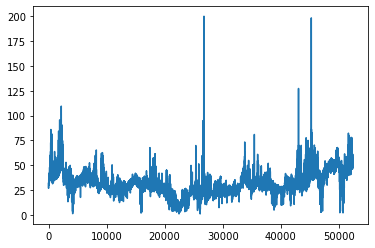

In [ ]:
from nixtla.data.datasets.epf import EPF, EPFInfo
import matplotlib.pyplot as plt

dataset = ['NP']

Y_df, X_df, S_df = EPF.load_groups(directory='../data', groups=dataset)

X_df = X_df[['unique_id', 'ds', 'week_day']]
Y_min = Y_df.y.min()
#Y_df.y = Y_df.y - Y_min + 20

plt.plot(Y_df.y.values)
plt.show()

In [ ]:
result = evaluate_model(loss_function=mae, mc=mc, Y_df=Y_df, X_df=X_df, S_df=S_df, 
                        ds_in_test=728*24, shuffle_outsample=False, kwargs_loss={})
result

INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0.0         2016-12-27 2018-12-24 23:00:00
          1.0         2013-01-01 2016-12-26 23:00:00
INFO:root:Total data 			52416 time stamps
INFO:root:Available percentage=100.0, 	52416 time stamps
INFO:root:Insample  percentage=66.67, 	34944.0 time stamps
INFO:root:Outsample percentage=33.33, 	17472.0 time stamps
INFO:root:

INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0.0         2013-01-01 2016-12-26 23:00:00
          1.0         2016-12-27 2018-12-24 23:00:00
INFO:root:Total data 			52416 time stamps
INFO:root:Available percentage=100.0, 	52416 time stamps
INFO:root:Insample  percentage=33.33, 	17472.0 time 



============================== Start fitting ==============================
Step: 10, Time: 2.874, Insample SMYL: 0.05373, Outsample MAE: 3.52510
Step: 10, Time: 3.200, Insample SMYL: 0.05373, Outsample MAE: 3.52510
==============================  End fitting  ==============================


y_true.shape (#n_series, #n_fcds, #lt)  (728, 24)
y_hat.shape (#n_series, #n_fcds, #lt)  (728, 24)




{'loss': 3.525100053189111,
 'mc': {'model': 'new_rnn',
  'input_size_multiplier': 7,
  'output_size': 24,
  'dilations': [[1, 2], [7]],
  'es_component': 'multiplicative',
  'cell_type': 'LSTM',
  'state_hsize': 50,
  'add_nl_layer': False,
  'seasonality': [24],
  'n_iterations': 10,
  'early_stopping': 10,
  'eval_freq': 10,
  'batch_size': 32,
  'learning_rate': 0.0005,
  'lr_scheduler_step_size': 100,
  'lr_decay': 0.8,
  'per_series_lr_multip': 1.5,
  'gradient_eps': 1e-08,
  'gradient_clipping_threshold': 20,
  'rnn_weight_decay': 0.0,
  'noise_std': 0.0005,
  'level_variability_penalty': 10,
  'testing_percentile': 50,
  'training_percentile': 50,
  'random_seed': 1,
  'loss': 'SMYL',
  'val_loss': 'MAE',
  'len_sample_chunks': 672,
  'window_sampling_limit': 500000,
  'complete_inputs': False,
  'complete_sample': False,
  'idx_to_sample_freq': 24,
  'val_idx_to_sample_freq': 24,
  'n_series_per_batch': 1,
  'normalizer_y': None,
  'normalizer_x': None},
 'y_true': array([[24.

In [ ]:
trials = hyperopt_tunning(space=nbeats_space, hyperopt_iters=2, loss_function=mae, Y_df=Y_df, X_df=X_df, S_df=S_df,
                          ds_in_test=728*24, shuffle_outsample=False)

  0%|          | 0/2 [00:00<?, ?trial/s, best loss=?]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.016478 seconds
INFO:hyperopt.tpe:TPE using 0 trials
INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0.0         2016-12-27 2018-12-24 23:00:00
          1.0         2013-01-01 2016-12-26 23:00:00
INFO:root:Total data 			52416 time stamps
INFO:root:Available percentage=100.0, 	52416 time stamps
INFO:root:Insample  percentage=66.67, 	34944.0 time stamps
INFO:root:Outsample percentage=33.33, 	17472.0 time stamps
INFO:root:

INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0.0         2013-01-01 2016-12-26 23:00:00
          1.0         2016-12-27 2018-12-24 23:00:00
INFO:root:Total data 			52416 time stamps
INFO:roo

============================== Start fitting ==============================
Step: 10, Time: 1.164, Insample MAE: 6.03131, Outsample MAE: 6.36892
==============================  End fitting  ==============================
y_true.shape (#n_series, #n_fcds, #lt)               
(1, 728, 24)                                         
y_hat.shape (#n_series, #n_fcds, #lt)                
(1, 728, 24)                                         
 50%|█████     | 1/2 [00:01<00:01,  1.73s/trial, best loss: 6.368921756744385]

INFO:hyperopt.tpe:build_posterior_wrapper took 0.021106 seconds
INFO:hyperopt.tpe:TPE using 1/1 trials with best loss 6.368922
INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0.0         2016-12-27 2018-12-24 23:00:00
          1.0         2013-01-01 2016-12-26 23:00:00
INFO:root:Total data 			52416 time stamps
INFO:root:Available percentage=100.0, 	52416 time stamps
INFO:root:Insample  percentage=66.67, 	34944.0 time stamps
INFO:root:Outsample percentage=33.33, 	17472.0 time stamps
INFO:root:

INFO:root:Train Validation splits

INFO:root:                              ds                    
                             min                 max
unique_id sample_mask                               
NP        0.0         2013-01-01 2016-12-26 23:00:00
          1.0         2016-12-27 2018-12-24 23:00:00
INFO:root:Total data 			

============================== Start fitting ==============================   
Step: 10, Time: 0.294, Insample MAE: 2.25357, Outsample MAE: 2.81257          
==============================  End fitting  ==============================   
y_true.shape (#n_series, #n_fcds, #lt)                                        
(1, 728, 24)                                                                  
y_hat.shape (#n_series, #n_fcds, #lt)                                         
(1, 728, 24)                                                                  
100%|██████████| 2/2 [00:02<00:00,  1.22s/trial, best loss: 2.812570810317993]


In [ ]:
trials.trials

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': 4.577489376068115,
   'mc': {'activation': 'selu',
    'batch_normalization': False,
    'batch_size': 256,
    'complete_inputs': False,
    'complete_sample': False,
    'dropout_prob_exogenous': 0.3680239643206844,
    'dropout_prob_theta': 0.009343118485134028,
    'early_stopping': 16,
    'eval_freq': 50,
    'exogenous_n_channels': 4.0,
    'frequency': 'H',
    'idx_to_sample_freq': 24,
    'initialization': 'he_normal',
    'input_size_multiplier': 7,
    'l1_theta': 0,
    'learning_rate': 0.000900505803667316,
    'len_sample_chunks': None,
    'loss': 'MAE',
    'loss_hypar': 0.5,
    'lr_decay': 0.38412961772271936,
    'model': 'nbeats',
    'n_blocks': (1, 1),
    'n_harmonics': 1,
    'n_hidden': 364,
    'n_iterations': 10,
    'n_layers': (2, 2),
    'n_lr_decay_steps': 3,
    'n_polynomials': 2,
    'n_series_per_batch': 1,
    'n_val_weeks': 104,
    'normalizer_x': 'median',
    'normalizer_y': None,
  